In [2]:
#a place for functions related to analysis of PL data
#%%
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def sample_name(chemistry,experiment,laser,power,OD,integration):
    return chemistry+'_'+experiment+'_'+laser+'_'+power+'_'+OD+'_'+integration+'.csv'

def find_nearest(array, value):
    #array is a 1D vector of wavelengths
    #value is the specific wavelength for which want the index
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def trim_data(x, data, limit1, limit2):
    #x is a 1D array of two theta or q values
    #data is an array of x-ray intensities
    #limit1 and limit2 are what you'd like to trime your data to 
    set1 = find_nearest(x,limit1)
    set2 = find_nearest(x,limit2)
    return x[set1:set2], data[set1:set2,:]

def weighted_PL(wave,intensity):
    return np.sum(wave*intensity)/np.sum(intensity)

def weighted_PL_lim(wave,intensity,lim1,lim2):
    start = find_nearest(wave,lim1)
    end = find_nearest(wave,lim2)
    return np.sum(wave[start:end]*intensity[start:end])/np.sum(intensity[start:end])

def exp_fit(x,a,b,c):
    x = np.array(x)
    return -1*a*np.exp(x*-1*b)+c


# %%

In [2]:
pip install lmfit

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import required packages
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.optimize import curve_fit
# from PLfunctions import sample_name, find_nearest, weighted_PL, trim_data, exp_fit
import math
import scipy.optimize 
from lmfit import models
from numpy import random
from scipy import signal

class PLspec:
    """
    PLspec accepts the path to a .csv file containing spectrometer output with two columns 
    named "Wavelength" and "Intensity." The wavelength series is saved in PLspec.W, the 
    intensity series in PLspec.I, the photon energy series corresponding to the wavelength 
    in PLspec.I. The intensity-weighted wavelength/photon energy over time is also calculated
    upon initializing and saved in PLspec.IweightedW or PLspec.IweightedE.
    
    """
    def __init__(self, file):
        """Initiates the PLspec class by reading a spectrum csv into a dataframe
        
        Args:
            file: path to a .csv file containing spectrometer output with at least two columns that
            are named "Wavelength" and "Intensity." Intensity weight averages for wavelength and 
            photon energy are made available
        Returns:
            None
        
        """
        self.c = 2.99792458e8 * 1e9 #
        self.h = 4.1357e-15 #eV*s
        self.file = file
        self.og = pd.read_csv(self.file, index_col=None, header=0)
        self.df = self.og
        self.formatData()
        
    def formatData(self):
        """Perform basic intensity weighted average calculations and save data to appropriate attributes
        
        Args:
            None
        
        Returns:
            None
        
        """
        self.W = self.df["Wavelength"]
        self.I = self.df["Intensity"]
        self.E = self.c/self.W*self.h
        self.IweightedW = sum(self.I*self.W)/sum(self.I)
        self.IweightedE = sum(self.I*self.E)/sum(self.I)
        
    def plotW(self):
        """Plot the spectrum in the format of intensity versus wavelength
        
        Args:
            None
        
        Returns:
            None
        
        """
        fig, ax = plt.subplots()
        ax.scatter(self.W, self.I,s=4)
        ax.set_xlabel("Wavelength(nm)")
        ax.set_ylabel("Intensity(Counts)")
        ax.set_title(self.file, {'fontsize': "small",})
        
    
    def plotE(self):
        """Plot the spectrum in the format of intensity versus photon energy
        
        Args:
            None
        
        Returns:
            None
        
        """
        fig, ax = plt.subplots()
        ax.scatter(self.E, self.I,s=4)
        ax.set_xlabel("Photon Energy(eV)")
        ax.set_ylabel("Intensity(Counts)")
        ax.set_title(self.file, {'fontsize': "small",})
        
        
    def retore(self):
        """Remove the cutoff for the spectrum data
        
        Args:
            None
        
        Returns:
            None
        
        """
        self.df = self.og 
        self.formatData()

        
    def narrow(self, Wmin=550, Wmax=1000):
        """Enact the cutoff for the spectrum data
        
        Args:
            Wmin: optional minimum wavelength cutoff to focus on a narrower range of data, won't be
                implmented until PLspec.narrow() is called
            Wmax: optional maximum wavelength cutoff to focu on a narrower range of data, won't be
                implmented until PLspec.narrow() is called
                
        Returns:
            None
        
        """
        self.Wmin = Wmin
        self.Wmax = Wmax
        self.minCond = self.df["Wavelength"]>self.Wmin
        self.maxCond = self.df["Wavelength"]<self.Wmax
        self.df = self.df[self.minCond & self.maxCond]
        self.formatData()
        
    
    def gaussian(self, x, mu, sigma, height):
        """Definition of a single gaussian function
        
        Args:
            x: input data over which gaussian values are calculated
            mu: the center of the gaussian 
            sigma: the standard deviation of the gaussian
            height: the scaling of the gaussian
                
        Returns:
            None
        """
        return height*np.exp(-(x - mu)**2/(2*sigma**2))


class PLevol:
    def __init__(self, folder):
        """Initiates the PLevol class by converting full spectrum csv into individual PLspec class.
        A series of intensity weighted wavelength over time and another series of intensity weighted
        photon energy over time is calculated.
        
        Args:
            folder: the path to folder/directory in which spectrometer files are stored
        
        Returns:
            None
        
        """
        self.og = [PLspec(file) for file in sorted(glob.glob(folder+"/*.csv"))]
        self.PLs = self.og
        self.Wavgseries = [spec.IweightedW for spec in self.PLs]
        self.Eavgseries = [each.IweightedE for each in self.PLs]
        
    def restore(self):
        """Remove the cutoff for the spectrum data
        
        Args:
            None
        
        Returns:
            None
        
        """
        self.PLs = self.og 
        
    def narrow(self, Wmin=550, Wmax=1000):
        """Enact the cutoff for the spectrum data
        
        Args:
            file: path to a .csv file containing spectrometer output with at least two columns that
            are named "Wavelength" and "Intensity"
            Wmin: optional minimum wavelength cutoff to focus on a narrower range of data, won't be
            implmented until PLspec.narrow() is called
            Wmax: optional maximum wavelength cutoff to focu on a narrower range of data, won't be
            implmented until PLspec.narrow() is called
        
        Returns:
            None
        
        """
        [PL.narrow(Wmin, Wmax) for PL in self.og]
        self.Wavgseries = [each.IweightedW for each in self.PLs]
        self.Eavgseries = [each.IweightedE for each in self.PLs]

# Some of the following peak fitting code was originally written by Chris Ostrouchov
# You can find them here: https://chrisostrouchov.com/post/peak_fit_xrd_python/
# Qingmu Deng rewrote most of the original code for PL Fitting for the Belis Lab at Wellesley College
class Fitter():
    def __init__(self):
        self.output_series=[]
        self.first_pass=True


    def basicparam(self, spec):
        x = spec['x']
        y = spec['y']
        x_min = np.min(x)
        x_max = np.max(x)
        x_range = x_max - x_min
        y_max = np.max(y)
        return None, None, x, y, x_min, x_max, x_range, y_max


    def spec_gen(self, x, y, peaks, model='GaussianModel'):
        return {
            'x': x,
            'y': y,
            'model': [{'type': model} for i in range(len(peaks))]
            }

    def common_param_set(self, mdl, peak, error, y_max):
        """ Specify bounds for relevant model parameters
        Args:
            mdl: a lmfit model object
            peak: a list of [peak_x_value, peak_y_value]
            error: freedom a peak's center is given to the left and right in nm
            y_max: maximum y of the spectrum
        
        Returns:
            None
        """
        mdl.set_param_hint('sigma', min=5, max=50)
        mdl.set_param_hint('center', min=peak[0]-error, max=peak[0]+error)
        mdl.set_param_hint('height', min=1e-6, max=1.1*y_max)
        mdl.set_param_hint('amplitude', min=1e-6)
        
    def model_params_update(self, comp_model, model, params, model_params):
        """ Incorporate individual model and model parameters into composite models
        Args:
            comp_model: a lmfit composite model object that is the linear combination of individual model
            model: an individual lmfit model to be added to the composite model
            params: parameters for the composite model
            model_params: parameters of the single model to be added to the composite model parameters
        
        Returns:
            comp_model: a composite model combined with the additional model
            params: composite model parameters incorporated with the additional model parameters
        """
        if params is None:
            params = model_params
        else:
            params.update(model_params)
        if comp_model is None:
            comp_model = model
        else:
            comp_model = comp_model + model
        return comp_model, params


    def peaks2spec(self, x, y, peak_widths=(10,200)):
        """Generate an initial model from CWT peak fitting
        Calls my_modelgen()
        Args:
            x: spectrum x/wavelength data series
            y: spectrum y/intensity data series
            peak_widths: allowable peak width for CWT search
        
        Returns:
            peak_indicies: peak indices identified by CWT
            composite_model: fully assembled composite model for fitting
            model_params: fully assembled composite model parameters for fitting
        """
        peak_indicies = signal.find_peaks_cwt(y, peak_widths)
    #     print(peak_index)
        temp=[]
        # print(x)
        # print(peak_indicies)
        for peak_index in peak_indicies:
            if x[peak_index] > 600.0 and x[peak_index] < 800:
                temp.append(peak_index)
        peak_indicies=np.array(temp)
        spec = self.spec_gen(x, y, peak_indicies)
        
        composite_model, model_params = self.my_modelgen(spec, peak_indicies, peak_widths)

        return peak_indicies, composite_model, model_params
    

    def my_modelgen(self, spec, peak_indicies, peak_widths, error=10):
        """ Generate an initial composite model and model parameters based on CWT peak detection
        Args:
            spec: initial model specification variable, see spec_gen()
            peak_indicies: peak indices identified by CWT
            peak_widths: allowable peak width for CWT search
            error: freedom a peak's center is given to the left and right in nm
        
        Returns:
            
            composite_model: fully assembled composite model for fitting
            model_params: fully assembled composite model parameters for fitting
        """
        # Initiate and extract basic parameters from the specifications
        composite_model, params, x, y, x_min, x_max, x_range, y_max = self.basicparam(spec)
        
        # For each model specified in the specification, set their parameters bounds 
        # and add them together to form a composite model
        for (i, basis_func), peak_index in zip(enumerate(spec['model']), peak_indicies):
            prefix = f'm{i}_'
            model = getattr(models, basis_func['type'])(prefix=prefix)
            if basis_func['type'] in ['GaussianModel', 'LorentzianModel', 'VoigtModel','PseudoVoigtModel']: # for now VoigtModel has gamma constrained to sigma
                model.set_param_hint('sigma', min=5, max=50)#x_range)
                model.set_param_hint('center', min=x[peak_index]-error, max=x[peak_index]+error)
                model.set_param_hint('height', min=1e-6, max=1.1*y_max)
                model.set_param_hint('amplitude', min=1e-6)
                # avoid using default parameter guess
                default_params = {
                    prefix+'center': x[peak_index],
                    prefix+'height': y[peak_index],
                    prefix+'sigma': 50#x_range / len(x) * np.min(peak_widths)
                }
            else:
                raise NotImplemented(f'model {basis_func["type"]} not implemented yet')
            
            if 'help' in basis_func:  # allow override of settings in parameter
                for param, options in basis_func['help'].items():
                    model.set_param_hint(param, **options)
                                    
            # make model parameters based on the 
            model_params = model.make_params(**default_params, **basis_func.get('params', {}))
            # Add up each individual models and update their parameters accordingly
            composite_model, params = self.model_params_update(composite_model, model, params, model_params) 
                                    
        return composite_model, params
                                 
                                    
                                    
    def both2spec(self, x, y, peak_widths=(10,200)):
        """ Generate both a model from CWT peak fitting and a model from last peak fitting parameters
        Calls last_modelgen() and cwt_modelgen()    
        
        Args:
            x: spectrum x/wavelength data series
            y: spectrum y/intensity data series
            peak_widths: allowable peak width for CWT search
        
        Returns:
            peak_indicies: peak indices
            composite_model: fully assembled composite model for fitting
            model_params: fully assembled composite model parameters for fitting    
        """
        
        # Do a fresh extraction of peak position with CWT
        peak_indicies = signal.find_peaks_cwt(y, peak_widths)
        peaks_cwt=[]
        for peak_index in peak_indicies:
            if x[peak_index] > 600.0 and x[peak_index] < 800:
                peaks_cwt.append([x[peak_index],y[peak_index]])
        
        # Consider the peak positions from the last fitting routine as well
        last_peaks=[]
        if self.output_series != []:
            last_out=self.output_series[-1]
            for each in last_out.params:
                if each.find("center") != -1:
                    amp = last_out.params[each[:3]+'amplitude']
                    if amp.value < 40:
                        continue
                    last_peaks.append([last_out.params[each].value, last_out.params[each[:3]+'height'].value,\
                                    last_out.params[each[:3]+'sigma'].value])
        
        # Generate a first model based on CWT-extracted peaks
        pk_spec = self.spec_gen(x, y, peaks_cwt)
        pk_model, pk_params = self.cwt_modelgen(pk_spec, peaks_cwt, peak_widths, error=10)
        # Generate a second model based on last peakfitting parameters
        lt_spec = self.spec_gen(x, y, last_peaks)
        lt_model, lt_params = self.last_modelgen(pk_spec, last_peaks, peak_widths, error=10)
        
        # Get the CWT peak locations for comparison
        peaks_cwt=[each[0] for each in peaks_cwt]
        return peaks_cwt, pk_model, pk_params, lt_model, lt_params


    def last_modelgen(self, spec, peaks, peak_widths, error=10):
        """ Generate a composite model and model parameters based on last fitting parameters
        Args:
            spec: initial model specification variable, see spec_gen()
            peak_indicies: peak indices identified by CWT
            peak_widths: allowable peak width for CWT search
            error: freedom a peak's center is given to the left and right in nm
        
        Returns:
            composite_model: fully assembled composite model for fitting
            model_params: fully assembled composite model parameters for fitting
        """
        # Initiate and extract basic parameters from the specifications
        composite_model, params, x, y, x_min, x_max, x_range, y_max = self.basicparam(spec)
        
        # For each model specified in the specification, set their parameters bounds 
        # and add them together to form a composite model
        for (i, basis_func), peak in zip(enumerate(spec['model']), peaks):
            prefix = f'm{i}_'
            model = getattr(models, basis_func['type'])(prefix=prefix)
            if basis_func['type'] in ['GaussianModel', 'LorentzianModel', 'VoigtModel','PseudoVoigtModel']: # for now VoigtModel has gamma constrained to sigma

                # model is passed by reference here so no need to return anything
                self.common_param_set(model, peak,error, y_max)

                # avoid using default parameter guess
                default_params = {
                    prefix+'center': peak[0],
                    prefix+'height': peak[1],
                    prefix+'sigma': peak[2]#x_range / len(x) * np.min(peak_widths)#peak[2]
                }
            else:
                raise NotImplemented(f'model {basis_func["type"]} not implemented yet')
            
            if 'help' in basis_func:  # allow override of settings in parameter
                for param, options in basis_func['help'].items():
                    model.set_param_hint(param, **options)
            
            # make model parameters based on the 
            model_params = model.make_params(**default_params, **basis_func.get('params', {}))
            # Add up each individual models and update their parameters accordingly
            composite_model, params = self.model_params_update(composite_model, model, params, model_params)  

        return composite_model, params
                                 

    def cwt_modelgen(self, spec, peaks, peak_widths, error=10):
        """ Generate a composite model and model parameters based on CWT peak detections
        Args:
            spec: initial model specification variable, see spec_gen()
            peak_indicies: peak indices identified by CWT
            peak_widths: allowable peak width for CWT search
            error: freedom a peak's center is given to the left and right in nm
        
        Returns:
            composite_model: fully assembled composite model for fitting
            model_params: fully assembled composite model parameters for fitting
        """
        # Initiate and extract basic parameters from the specifications
        composite_model, params, x, y, x_min, x_max, x_range, y_max = self.basicparam(spec)
        
        # For each model specified in the specification, set their parameters bounds 
        # and add them together to form a composite model                       
        for (i, basis_func), peak in zip(enumerate(spec['model']), peaks):
            prefix = f'm{i}_'
            model = getattr(models, basis_func['type'])(prefix=prefix)
            if basis_func['type'] in ['GaussianModel', 'LorentzianModel', 'VoigtModel','PseudoVoigtModel']: # for now VoigtModel has gamma constrained to sigma
                # model is passed by reference here so no need to return anything
                self.common_param_set(model, peak,error, y_max)
                # avoid using default parameter guess
                default_params = {
                    prefix+'center': peak[0],
                    prefix+'height': peak[1],
                    prefix+'sigma': x_range / len(x) * np.min(peak_widths)#peak[2]
                }
            else:
                raise NotImplemented(f'model {basis_func["type"]} not implemented yet')
            
            if 'help' in basis_func:  # allow override of settings in parameter
                for param, options in basis_func['help'].items():
                    model.set_param_hint(param, **options)
            
            # make model parameters based on the 
            model_params = model.make_params(**default_params, **basis_func.get('params', {}))
            # Add up each individual models and update their parameters accordingly
            composite_model, params = self.model_params_update(composite_model, model, params, model_params)                       

        return composite_model, params

    def fit(self, PLevol_obj, nframe=5, startIndex=2, verbose=True):
        """
        Args:
            PLevol_obj: a PLevol object, see class PLevol()
            nframe: number of frames of perform fitting over
            startIndex: the number of frame to start performing peak fitting
            verbose: whether or not to print out chi-sqr and plot fitting results
        
        Returns:
            None
        """
        self.output_series=[]
        self.first_pass=True
        for i in np.arange(0,nframe)+startIndex:
    
            index=i
            x = np.array(PLevol_obj.PLs[index].W)
            y = np.array(PLevol_obj.PLs[index].I - PLevol_obj.PLs[0].I)
            fig, ax = plt.subplots(1, 3, sharey=True, figsize=(15, 4))
            fig.suptitle('Frame '+str(i), fontsize=16)
            ax[0].scatter(x, y, s=4, c='b')
            
            output = None
            out1 = None
            out2 = None
            if self.first_pass:
                peaks_found, composite_model, params = self.peaks2spec(x, y)
                output = composite_model.fit(y, params, x=x)
            else:
                peaks_found, pk_model, pk_params, lt_model, lt_params = self.both2spec(x, y)
                out1 = pk_model.fit(y, pk_params, x=x)
                out2 = lt_model.fit(y, lt_params, x=x)
                if out1.chisqr <= out2.chisqr:
                    output=out1
                else:
                    output=out2
                if verbose: print("Frame", index ,"CWT Chi-sqr",out1.chisqr,"\t Last  Chi-sqr", out2.chisqr)
            
            if verbose:
                if not self.first_pass:
                    for peak in peaks_found:
                        ax[0].axvline(x=peak, c='black', linestyle='dotted')
                        
                    comps = out1.eval_components(x=x)
                    for each in comps:
                        ax[1].plot(x, comps[each], '--', label=each)
                    ax[1].legend()
                    ax[1].set_title("Peak Fitting with CWT Peak Parameters")

                    comps = out2.eval_components(x=x)
                    for each in comps:
                        ax[2].plot(x, comps[each], '--', label=each)
                    ax[2].legend()
                    ax[2].set_title("Peak Fitting with Last Fitting Parameters")
                else:
                    for peak in peaks_found:
                        ax[0].axvline(x=x[peak], c='black', linestyle='dotted')

                comps = output.eval_components(x=x)
                for each in comps:
                    ax[0].plot(x, comps[each], '--', label=each)
                ax[0].legend()
                ax[0].set_title("Best Fit")
                ax[1].scatter(x, y, s=4, c='y')
                ax[2].scatter(x, y, s=4, c='y')
                # plt.close()

            self.output_series.append(output)
            self.first_pass=False # other than the first iteration, use both2spec to find the best fit
    
    def peak_avg(self, out):
        """ Calculated peak height weighted average
        Args:
            out: a lmfit output object
        
        Returns:
            peak height weighted average
        """
        numer=0
        denom=0
        for each in out.params:
            if each.find("center") != -1:
                denom += out.params[each[:3]+'height'].value
                numer += out.params[each].value*out.params[each[:3]+'height'].value
        return numer/denom

    def plot_peakAvg(self):
        """ Plot a series of peak height weighted average from self.output_series
        Args:
            None
        
        Returns:
            None
        """
        fig, ax = plt.subplots(1,1)
        self.avgSeries = [self.peak_avg(each) for each in self.output_series]
        ax.scatter(np.arange(len(self.avgSeries)), self.avgSeries, label="Peak-Height-Weighted")
        ax.set_ylabel("Wavelength (nm)")
        ax.set_ylabel("Frame Number")
        ax.set_title("Peak-Height-Weighted Wavelength Average")


In [4]:
#Calculate Bromine and Iodine Centers
#%% identify location of iodine file
path = r'/Volumes/GoogleDrive/Shared drives/Wellesley Solar/Current Projects/ Hoke Effect/PL_data_300720/All chemistries' # use your path
all_files = sorted(glob.glob(path + "/*.csv"))
iodine = np.array(pd.read_csv(all_files[2],index_col=None, header=0))
#%%process data for iodine
lim1 = 560
lim2 = 875
wave_iodine, iodine_trim = trim_data(iodine[:,1],iodine[:,2:],lim1,lim2)
iodine0 = iodine_trim[:,0]

#%%identify location of bromine file
path2 =r'/Volumes/GoogleDrive/Shared drives/Wellesley Solar/Current Projects/ Hoke Effect/PL_data_300720/BrData_old.csv'
bromine= np.array(pd.read_csv(path2,index_col=None, header=0))
#%%process data for iodine
wave_bromine = np.array(bromine[:,2])
bromine0 = np.array(bromine[:,5])

#%%find maximums
maxi_index = np.where(iodine0 == iodine0.max())
maxi_wave = wave_iodine[maxi_index]

maxbr_index = np.where(bromine0 == bromine0.max())
maxbr_wave = wave_bromine[maxbr_index]


<Figure size 576x432 with 0 Axes>

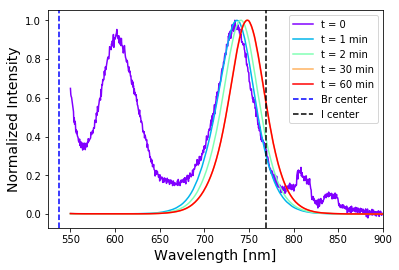

In [5]:
#adapted from combinedPL files to plot the first and last file of a set of files

#%% set up details of experiment and process data into a single dataframe
path = r'/Volumes/GoogleDrive/Shared drives/Wellesley Solar/Current Projects/ Hoke Effect/PL_data_300720/MAPbi25Br75/1hour' # use your path
all_files = sorted(glob.glob(path + "/*.csv"))

chem = 'MAPbI25Br75'
exp = '1 hour'
laser = '488nm'
power = '5mW'
OD = '1p5'
integration = '10ms'
first_background = True #Use first frame as background

exp_seq = [[120,60],[58*60,58]] #measurements in the format [[time1, frames1], [time2, frames2]]
lim1 = 550 #high energy cutoff
lim2 = 900 #low energy cutoff

#%% initialize timing and determine delays
# TODO this cell should be a function

time_1 = all_files[0].split(" ")[6].split("_") 
start_time = [int(x) for x in time_1]
start_sec = start_time[0]*60**2+start_time[1]*60+start_time[2]
time_2 = all_files[exp_seq[0][1]].split(" ")[-2].split("_") 
restart_time = [int(x) for x in time_2]
restart_sec = restart_time[0]*60**2+restart_time[1]*60+restart_time[2]
delay = restart_sec-start_sec

#%%
# TODO should make it such that this can accept an arbitrary experimental sequence

f_times = []
df = pd.read_csv(all_files[0])
fullset = df[["Wavelength"]]

for f_name in all_files[0:exp_seq[0][1]]:

    f_idx = int(f_name.split("-")[-1].split(".")[0])
    f_time = round(f_idx * exp_seq[0][0]/exp_seq[0][1], 2)
    f_times.append(f_time)

    df = pd.read_csv(f_name, index_col=None, header=0) #read file
    temp = df.add_suffix(str(f_time)) #link time to file 
    fullset = pd.concat([fullset, temp[["Intensity"+str(f_time)]]], axis=1) #add intensity data to file

for f_name in all_files[exp_seq[0][1]:]:

    f_idx = int(f_name.split("-")[-1].split(".")[0])
    f_time = round(f_idx * exp_seq[1][0]/exp_seq[1][1], 2)+delay
    f_times.append(f_time)

    df = pd.read_csv(f_name, index_col=None, header=0) #read file
    temp = df.add_suffix(str(f_time)) #link time to file 
    fullset = pd.concat([fullset, temp[["Intensity"+str(f_time)]]], axis=1) #add intensity data to file


#  Breaking down data for plotting full specta
#%%
fulldata = fullset.values.copy()
wave = fulldata[:,0]
PL = fulldata[:,1:]
#%%
if first_background:
    PL_back = PL
    ref = find_nearest(wave,900) #wavelength you will use as background

    for x in range(len(fullset.columns)-1):
        PL_back[:,x] = PL[:,x] - np.mean(PL[(ref-10):(ref+10),x]) 
    for x in range(len(fullset.columns)-1):
        PL_back[:,x] = PL_back[:,x] - PL_back[:,0]
    wave, PL_back = trim_data(wave,PL_back,lim1,lim2)

else: 
    # subtract background
    ref = find_nearest(wave,900) #wavelength you will use as background
    PL_back = PL

    for x in range(len(fullset.columns)-1):
        PL_back[:,x] = PL[:,x] - np.mean(PL[(ref-10):(ref+10),x]) 

    wave, PL_back = trim_data(wave,PL_back,lim1,lim2)

#%%
#plot set time files
plt.figure(num = 1, figsize=(8,6))
fig1,ax1 = plt.subplots()
ax1.set_xlabel('Wavelength [nm]',size=14) #Define x-axis label
ax1.set_ylabel('Normalized Intensity',size=14)#Define y-axis label
ax1.set_xlim([525,900])
evenly_spaced_interval = np.linspace(0, 1, 5)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]
#normalized
plt.plot(wave,PL_back[:,2]/max(PL_back[:,2]), color =  colors[0],label='t = 0')
plt.plot(wave,PL_back[:,29]/max(PL_back[:,29]), color = colors[1],label='t = 1 min')
plt.plot(wave,PL_back[:,59]/max(PL_back[:,59]), color = colors[2],label='t = 2 min')
plt.plot(wave,PL_back[:,-30]/max(PL_back[:,-30]), color = colors[3],label='t = 30 min')
plt.plot(wave,PL_back[:,-1]/max(PL_back[:,-1]), color = colors[4],label='t = 60 min')
#not normalized version
#plt.plot(wave,PL_back[:,1], color =  colors[0],label='t = 0')
#plt.plot(wave,PL_back[:,29], color = colors[1],label='t = 1 min')
#plt.plot(wave,PL_back[:,59], color = colors[2],label='t = 2 min')
#plt.plot(wave,PL_back[:,-30], color = colors[3],label='t = 30 min')
#plt.plot(wave,PL_back[:,-1], color = colors[4],label='t = 60 min')
#add bromine and iodine maximum points
#plt.plot(float(maxbr_wave),1, 'o', color='blue', label = 'Br center')
#plt.plot(float(maxi_wave),1, 'o', color='black', label = 'I center')
plt.axvline(x=float(maxbr_wave), color='blue', linestyle='--',label = 'Br center')
plt.axvline(x=float(maxi_wave), color='black', linestyle='--',label = 'I center')
plt.legend(loc="upper right")
#plt.title('First and last PL files over 1 hour for'+ chem)

In [13]:
#%%calculate iodine fraction
#%pull all relevant files
path = r'/Volumes/GoogleDrive/Shared drives/Wellesley Solar/Current Projects/ Hoke Effect/PL_data_300720/All chemistries' # use your path
all_files = sorted(glob.glob(path + "/*.csv"))

# %% manually assign all data to chemistry
Br75 = np.array(pd.read_csv(all_files[0],index_col=None, header=0))
Br33 = np.array(pd.read_csv(all_files[1],index_col=None, header=0))
Br50 = np.array(pd.read_csv(all_files[3],index_col=None, header=0))
Br67 = np.array(pd.read_csv(all_files[4],index_col=None, header=0))
#%% trim data
lim1 = 560
lim2 = 875
wave_75, Br75_trim = trim_data(Br75[:,1],Br75[:,2:],lim1,680)
wave_50, Br50_trim = trim_data(Br50[:,1],Br50[:,2:],lim1,lim2)
wave_33, Br33_trim = trim_data(Br33[:,1],Br33[:,2:],lim1,lim2)
wave_67, Br67_trim = trim_data(Br67[:,1],Br67[:,2:],lim1,680)

maxi2br_index = np.where((Br33[:,-1]) == (Br33[:,-1]).max())
maxi2br_wave = (Br33[:,1])[maxi2br_index]
maxi5br5_index = np.where((Br50[:,-1]) == (Br50[:,-1]).max())
maxi5br5_wave = (Br50[:,1])[maxi5br5_index]
maxibr2_index = np.where((Br67[:,-1]) == (Br67[:,-1]).max())
maxibr2_wave = (Br67[:,1])[maxi5br5_index]
maxi25br75_index = np.where((Br75[:,-1]) == (Br75[:,-1]).max())
maxi25br75_wave = (Br75[:,1])[maxi25br75_index]

#%%calculate average final position
avgfinal = np.average([float(maxibr2_wave),float(maxi5br5_wave),float(maxi25br75_wave)])

print('iodine max: '+ str(maxi_wave))
print('bromine max: '+ str(maxbr_wave))
print('i2br max: '+ str(maxi2br_wave))
print('i5br5 max: '+ str(maxi5br5_wave))
print('ibr2 max: '+ str(maxibr2_wave))
print('i25br75 max: '+ str(maxi25br75_wave))
print('average final of majority bromine compositions ' +str(avgfinal))


iodine max: [769.62201746]
bromine max: [537.75695224]
i2br max: [711.41443337]
i5br5 max: [751.50916315]
ibr2 max: [751.50916315]
i25br75 max: [748.13687114]
average final of majority bromine compositions 750.3850658152123


In [14]:
avgfinal/(float(maxi_wave)-float(maxbr_wave))

3.2363006694972